In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.dates as mdates
import seaborn as sns

/Users/asumisaito/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/asumisaito/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/asumisaito/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import classification_report
from sklearn import ensemble
from sklearn.metrics import confusion_matrix

/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 1. Read data

In [3]:
# train
df = pd.read_csv('/Users/asumisaito/Downloads/dengue_features_train.csv')
df2 = pd.read_csv('/Users/asumisaito/Downloads/dengue_labels_train.csv')
df.head(3)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.12260,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.16990,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.03225,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4


In [19]:
train = pd.merge(df, df2, on = ['city', 'year', 'weekofyear'])

### get year and month

In [20]:
import datetime
train['date'] = train['week_start_date'].astype(str).apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))

In [11]:
train.date.describe()

count                    1456
unique                   1049
top       2005-01-29 00:00:00
freq                        2
first     1990-04-30 00:00:00
last      2010-06-25 00:00:00
Name: date, dtype: object

In [21]:
from datetime import date
train['month'] = train['date'].dt.month

### convert city to dummy

In [22]:
mapping = {'sj': 0, 'iq': 1}
train2 = train.replace(mapping)
train2.head(3)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,date,month
0,0,1990,18,1990-04-30,0.12260,0.103725,0.198483,0.177617,12.42,297.572857,...,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4,1990-04-30,4
1,0,1990,19,1990-05-07,0.16990,0.142175,0.162357,0.155486,22.82,298.211429,...,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5,1990-05-07,5
2,0,1990,20,1990-05-14,0.03225,0.172967,0.157200,0.170843,34.54,298.781429,...,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4,1990-05-14,5


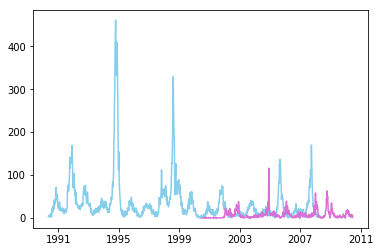

In [58]:
x0 = train2[train2.city == 0].date
x1 = train2[train2.city == 1].date
y0 = train2[train2.city == 0].total_cases
y1 = train2[train2.city == 1].total_cases
plt.plot(x0, y0, color = 'skyblue')
plt.plot(x1, y1, color = 'orchid')
plt.show()

# 2. Model

In [24]:
list(train2)

['city',
 'year',
 'weekofyear',
 'week_start_date',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 'total_cases',
 'date',
 'month']

In [25]:
features=[
    'city',
 'year',
 'weekofyear',
 #'week_start_date',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 #'total_cases',
 #'date',
 'month'
]

In [29]:
train3 = train2.dropna()
X = train3.loc[:, features]
y = train3.loc[:, ['total_cases']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### 1. Gradient Boosting

In [32]:
from sklearn.metrics import mean_absolute_error
gb = ensemble.GradientBoostingRegressor()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
MAE = mean_absolute_error(y_test, y_pred)
print('mean absolute error: ', MAE)

mean absolute error:  12.206742733740356


/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [33]:
gb

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [ ]:
# 14:58 - 

In [37]:
# grid search cv
gb_parameters = {'n_estimators': [100, 300, 500], 
                 'learning_rate': [0.001, 0.01, 0.1], 
                 'max_depth': range(2, 7, 2)
                }
gb_grid = GridSearchCV(gb, param_grid = gb_parameters, cv = 3, verbose=1)
gb_grid.fit(X_train, y_train)

gb_params = gb_grid.best_params_

tuned_gb = ensemble.GradientBoostingRegressor(**gb_params)
tuned_gb.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expec

/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expec

/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expec

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [39]:
y_pred = tuned_gb.predict(X_test)
MAE = mean_absolute_error(y_test, y_pred)
print('mean absolute error: ', MAE)

mean absolute error:  11.19453715648107


In [43]:
# grid search cv
gb_parameters = {'n_estimators': [500, 700, 1000], 
                 'learning_rate': [0.001, 0.01], 
                 'max_depth': range(2, 7, 2)
                }
gb_grid = GridSearchCV(gb, param_grid = gb_parameters, cv = 5, verbose=1)
gb_grid.fit(X_train, y_train)

gb_params = gb_grid.best_params_

tuned_gb = ensemble.GradientBoostingRegressor(**gb_params)
tuned_gb.fit(X_train, y_train)
y_pred = tuned_gb.predict(X_test)
MAE = mean_absolute_error(y_test, y_pred)
print('mean absolute error: ', MAE)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expec

/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expec

/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.8min finished
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


mean absolute error:  11.301814883036677


In [46]:
tuned_gb

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=6, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [44]:
import xgboost as xgb

In [50]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
                          colsample_bytree = 0.4, 
                          learning_rate = 0.1,
                          max_depth = 5, 
                          alpha = 0.9, 
                          n_estimators = 20)

model = xg_reg.fit(X_train,y_train)
y_pred = xg_reg.predict(X_test)
MAE = mean_absolute_error(y_test, y_pred)
print('mean absolute error: ', MAE)

mean absolute error:  12.008324269453684


# 3. Model by city

In [61]:
sj = train3[train3.city == 0]
iq = train3[train3.city == 1]

In [62]:
# sj
X = sj.loc[:, features]
y = sj.loc[:, ['total_cases']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [63]:
gb = ensemble.GradientBoostingRegressor()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
MAE = mean_absolute_error(y_test, y_pred)
print('mean absolute error: ', MAE)

mean absolute error:  15.753227059304539


/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [64]:
# iq
X = iq.loc[:, features]
y = iq.loc[:, ['total_cases']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

gb = ensemble.GradientBoostingRegressor()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
MAE = mean_absolute_error(y_test, y_pred)
print('mean absolute error: ', MAE)

mean absolute error:  4.217220543577337


/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


- perhaps iq performs better in separated model

# 4. Model with AutoRegressive features
- data includes both cities

In [67]:
data = train2.sort_values(by=['date'])
data.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,date,month
0,0,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4,1990-04-30,4
1,0,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5,1990-05-07,5
2,0,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4,1990-05-14,5
3,0,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3,1990-05-21,5
4,0,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6,1990-05-28,5


In [91]:
AR1  = data.groupby('city')['total_cases'].shift(1)
ar1 = pd.DataFrame(AR1)
ar1.columns = ['total_cases_lag1']

AR2  = data.groupby('city')['total_cases'].shift(2)
ar2 = pd.DataFrame(AR2)
ar2.columns = ['total_cases_lag2']

AR3  = data.groupby('city')['total_cases'].shift(3)
ar3 = pd.DataFrame(AR3)
ar3.columns = ['total_cases_lag3']

In [92]:
data2 = pd.concat([data, ar1, ar2, ar3], axis = 1)

test = data2[data2.city == 0]
test2 = test.loc[:, ['date','total_cases', 'total_cases_lag1', 'total_cases_lag2', 'total_cases_lag3']]
test2

,date,total_cases,total_cases_lag1,total_cases_lag2,total_cases_lag3
0,1990-04-30,4,NaN,NaN,NaN
1,1990-05-07,5,4.0,NaN,NaN
2,1990-05-14,4,5.0,4.0,NaN
3,1990-05-21,3,4.0,5.0,4.0
4,1990-05-28,6,3.0,4.0,5.0
5,1990-06-04,2,6.0,3.0,4.0
6,1990-06-11,4,2.0,6.0,3.0
7,1990-06-18,5,4.0,2.0,6.0
8,1990-06-25,10,5.0,4.0,2.0
9,1990-07-02,6,10.0,5.0,4.0


In [93]:
list(data2)

['city',
 'year',
 'weekofyear',
 'week_start_date',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 'total_cases',
 'date',
 'month',
 'total_cases_lag1',
 'total_cases_lag2',
 'total_cases_lag3']

In [94]:
features_ar=[
    'city',
 'year',
 'weekofyear',
 #'week_start_date',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 #'total_cases',
 #'date',
 'month',
 'total_cases_lag1',
 'total_cases_lag2',
 'total_cases_lag3'
]

In [111]:
data3 = data2.dropna()
X = data3.loc[:, features_ar]
y = data3.loc[:, ['total_cases']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [112]:
# 2 lags
gb = ensemble.GradientBoostingRegressor()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
MAE = mean_absolute_error(y_test, y_pred)
print('mean absolute error: ', MAE)

mean absolute error:  6.290473243943116


/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [113]:
# 3 lags
gb = ensemble.GradientBoostingRegressor()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
MAE = mean_absolute_error(y_test, y_pred)
print('mean absolute error: ', MAE)

mean absolute error:  6.338735737096754


/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


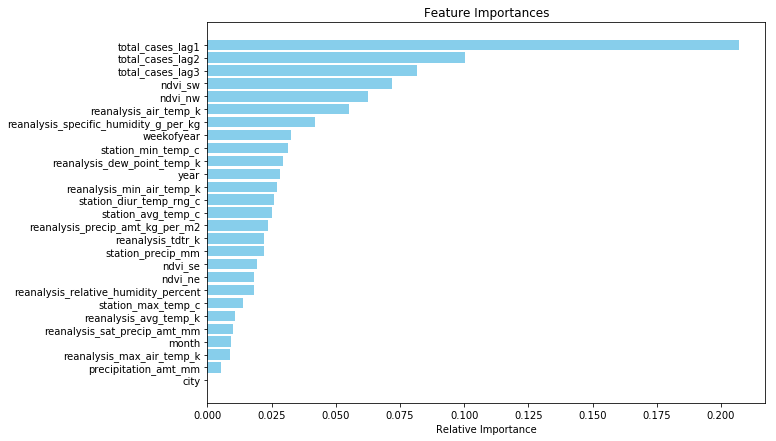

In [125]:
importance = gb.feature_importances_ 
indices = np.argsort(importance)

fig = plt.figure(figsize = (10, 7))

plt.title('Feature Importances')
plt.barh(range(len(indices)), importance[indices], color='skyblue', align='center')

plt.yticks(range(len(indices)), X_test.columns[indices])
plt.xlabel('Relative Importance')
plt.show()

In [118]:
result = pd.DataFrame(y_pred)
result.columns = ['y_pred']
result.head(3)

,y_pred
0,6.739014
1,2.461107
2,15.457172


In [119]:
result2 = pd.merge(result, train2, right_index=True, left_index=True)

In [120]:
result2

,y_pred,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,date,month
0,6.739014,0,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,...,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4,1990-04-30,4
1,2.461107,0,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,...,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5,1990-05-07,5
2,15.457172,0,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,...,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4,1990-05-14,5
3,5.511802,0,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,...,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3,1990-05-21,5
4,35.203685,0,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,...,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6,1990-05-28,5
5,26.374716,0,1990,23,1990-06-04,NaN,0.174850,0.254314,0.181743,9.58,...,17.212857,2.100000,28.114286,6.942857,34.4,23.9,39.1,2,1990-06-04,6
6,14.173204,0,1990,24,1990-06-11,0.112900,0.092800,0.205071,0.210271,3.48,...,17.234286,2.042857,27.414286,6.771429,32.2,23.3,29.7,4,1990-06-11,6
7,4.274302,0,1990,25,1990-06-18,0.072500,0.072500,0.151471,0.133029,151.12,...,17.977143,1.571429,28.371429,7.685714,33.9,22.8,21.1,5,1990-06-18,6
8,1.285953,0,1990,26,1990-06-25,0.102450,0.146175,0.125571,0.123600,19.32,...,17.790000,1.885714,28.328571,7.385714,33.9,22.8,21.1,10,1990-06-25,6
9,4.544436,0,1990,27,1990-07-02,NaN,0.121550,0.160683,0.202567,14.41,...,18.071429,2.014286,28.328571,6.514286,33.9,24.4,1.1,6,1990-07-02,7


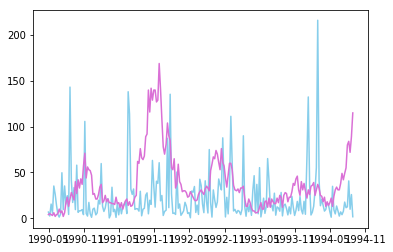

In [127]:
test = result2[result2.city == 0]

date1 = date(1994, 9, 1)
mask = (test['date'] <= date1)
sj = test.loc[mask]


x = sj.date
y0 = sj.y_pred
y1 = sj.total_cases

plt.plot(x, y0, color = 'skyblue')
plt.plot(x, y1, color = 'orchid')
plt.show()

In [131]:
aa  = sj.total_cases.tolist()
bb = sj.y_pred.tolist()
new_MAE = mean_absolute_error(aa, bb)
new_MAE

29.826773917527163

In [126]:
train.total_cases.describe()

count    1456.000000
mean       24.675137
std        43.596000
min         0.000000
25%         5.000000
50%        12.000000
75%        28.000000
max       461.000000
Name: total_cases, dtype: float64

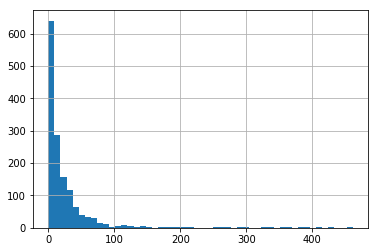

In [134]:
train.total_cases.hist(bins=50)
plt.show()

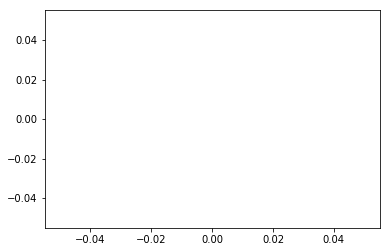

In [122]:
iq = result2[result2.city == 1]
x = iq.date
y0 = iq.y_pred
y1 = iq.total_cases

plt.plot(x, y0, color = 'skyblue')
plt.plot(x, y1, color = 'orchid')
plt.show()

In [135]:
list(train)

['city',
 'year',
 'weekofyear',
 'week_start_date',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 'total_cases',
 'date',
 'month']

In [147]:
check = train.loc[:,['ndvi_ne', 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw']]

check.head()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw
0,0.122600,0.103725,0.198483,0.177617
1,0.169900,0.142175,0.162357,0.155486
2,0.032250,0.172967,0.157200,0.170843
3,0.128633,0.245067,0.227557,0.235886
4,0.196200,0.262200,0.251200,0.247340


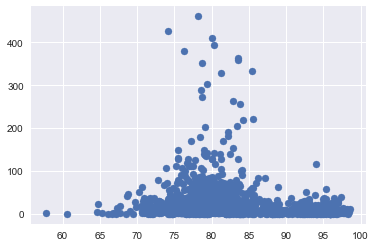

In [145]:
x = train.reanalysis_relative_humidity_percent
y = train.total_cases
plt.scatter(x, y)
sns.set()
plt.show()

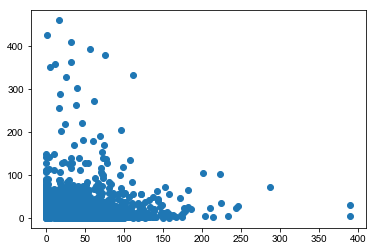

In [139]:
x = train.precipitation_amt_mm
y = train.total_cases
plt.scatter(x, y)
sns.set()
plt.show()

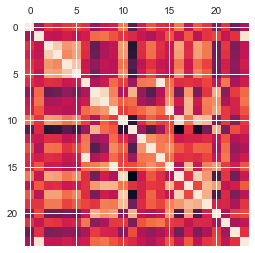

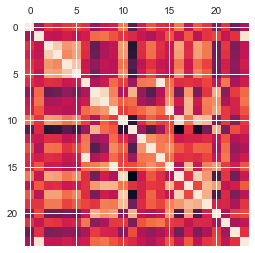

In [142]:
plt.matshow(train.corr())
plt.show()

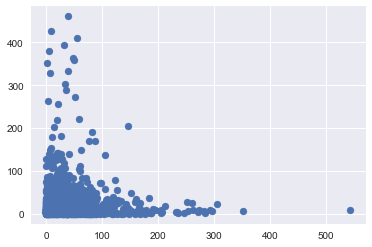

In [140]:
x = train.station_precip_mm
y = train.total_cases
plt.scatter(x, y)
sns.set()
plt.show()

## 5. Data cleaning incorporating datetime
- test data should be the last n datetime because the model shouldn't include future data to test


In [152]:
# check the range of datetime by city

# sj
sj = data2[data2.city == 0]
print('date of SJ')
print(sj.date.describe())

# iq
iq = data2[data2.city == 1]
print('date of IQ')
print(iq.date.describe())

date of SJ
count                     936
unique                    936
top       2000-05-13 00:00:00
freq                        1
first     1990-04-30 00:00:00
last      2008-04-22 00:00:00
Name: date, dtype: object
date of IQ
count                     520
unique                    520
top       2007-05-21 00:00:00
freq                        1
first     2000-07-01 00:00:00
last      2010-06-25 00:00:00
Name: date, dtype: object


In [156]:
# the range of test data to predict
test = pd.read_csv('/Users/asumisaito/Downloads/dengue_features_test.csv')
test.head(3)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.0189,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.0124,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0


In [157]:
test['date'] = test['week_start_date'].astype(str).apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
test.date.describe()

count                     416
unique                    269
top       2010-12-24 00:00:00
freq                        2
first     2008-04-29 00:00:00
last      2013-06-25 00:00:00
Name: date, dtype: object

In [158]:
# sj
sj_test = test[test.city == 'sj']
print('date of SJ')
print(sj_test.date.describe())

# iq
iq_test = test[test.city == 'iq']
print('date of IQ')
print(iq_test.date.describe())

date of SJ
count                     260
unique                    260
top       2010-12-24 00:00:00
freq                        1
first     2008-04-29 00:00:00
last      2013-04-23 00:00:00
Name: date, dtype: object
date of IQ
count                     156
unique                    156
top       2011-06-04 00:00:00
freq                        1
first     2010-07-02 00:00:00
last      2013-06-25 00:00:00
Name: date, dtype: object


#### Range of date in train data

#### SJ
- 936 data points
- 18 years
- from 1990/4/30 to 2008/4/22

#### IQ
- 520 data points
- 10 years
- from 2000/7/1 to 2010/6/25

#### Range of date in test data

#### SJ
- 260 rows
- 5 years
- from 2008/4/29 to 2013/4/23

#### IQ
- 156 rows
- 3 years
- from 2010/7/2 to 2013/6/25

#### -> Possible train-test-split
- for sj, train 13 years, test 5 years
    - train: 1990/4/30 to 2003/4/22
    - test:  2003/4/23 to 2008/4/22
- for iq, train 7 years, test 3 yaers
    - train: 2000/7/1 to 2007/6/25
    - test:  2007/6/26 to 2010/6/25

In [165]:
date_sj = date(2003, 4, 22)

sj2 = sj.dropna()

mask_sj_train = (sj2['date'] < date_sj)
mask_sj_test = (sj2['date'] >= date_sj)
sj_train = sj2.loc[mask_sj_train]
sj_test = sj2.loc[mask_sj_test]
print(sj2.shape, sj_train.shape, sj_test.shape, len(sj_train) + len(sj_test))

(724, 30) (518, 30) (206, 30) 724


In [166]:
date_iq = date(2007, 6, 25)

iq2 = iq.dropna()

mask_iq_train = (iq2['date'] < date_iq)
mask_iq_test = (iq2['date'] >= date_iq)
iq_train = iq2.loc[mask_iq_train]
iq_test = iq2.loc[mask_iq_test]
print(iq2.shape, iq_train.shape, iq_test.shape, len(iq_train) + len(iq_test))

(469, 30) (329, 30) (140, 30) 469


In [167]:
X_train_sj = sj_train.loc[:,features_ar]
y_train_sj = sj_train.loc[:,['total_cases']]
X_test_sj = sj_test.loc[:, features_ar]
y_test_sj = sj_test.loc[:, ['total_cases']]

In [168]:
gb = ensemble.GradientBoostingRegressor()
gb.fit(X_train_sj, y_train_sj)
y_pred_sj = gb.predict(X_test_sj)
MAE = mean_absolute_error(y_test_sj, y_pred_sj)
print('mean absolute error: ', MAE)

mean absolute error:  7.101280376984692


/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [169]:
rf = ensemble.RandomForestRegressor()
rf.fit(X_train_sj, y_train_sj)
y_pred_sj = rf.predict(X_test_sj)
MAE = mean_absolute_error(y_test_sj, y_pred_sj)
print('mean absolute error: ', MAE)

mean absolute error:  7.016504854368932


/Users/asumisaito/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [170]:
X_train_iq = iq_train.loc[:,features_ar]
y_train_iq = iq_train.loc[:,['total_cases']]
X_test_iq = iq_test.loc[:, features_ar]
y_test_iq = iq_test.loc[:, ['total_cases']]

In [171]:
gb = ensemble.GradientBoostingRegressor()
gb.fit(X_train_iq, y_train_iq)
y_pred_iq = gb.predict(X_test_iq)
MAE = mean_absolute_error(y_test_iq, y_pred_iq)
print('mean absolute error: ', MAE)

mean absolute error:  5.147102399503363


/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [172]:
rf = ensemble.RandomForestRegressor()
rf.fit(X_train_iq, y_train_iq)
y_pred_iq = rf.predict(X_test_iq)
MAE = mean_absolute_error(y_test_iq, y_pred_iq)
print('mean absolute error: ', MAE)

mean absolute error:  5.305714285714286


/Users/asumisaito/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


## 6. Model with autoregressive features by cities + grid search -> 1st submission (10/1)

In [173]:
# check submission-format
sub = pd.read_csv('/Users/asumisaito/Downloads/submission_format.csv')
print(sub.shape)
sub.head()

(416, 4)


,city,year,weekofyear,total_cases
0,sj,2008,18,0
1,sj,2008,19,0
2,sj,2008,20,0
3,sj,2008,21,0
4,sj,2008,22,0


In [174]:
print(test.shape)
test.head()

(416, 25)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,date
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,2008-04-29
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,2008-05-06
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,2008-05-13
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,2008-05-20
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1,2008-05-27


#### data cleaning for test data

In [175]:
test['date'] = test['week_start_date'].astype(str).apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
from datetime import date
test['month'] = test['date'].dt.month

In [177]:
test2 = test.sort_values(by=['date'])

AR1  = test2.groupby('city')['total_cases'].shift(1)
ar1 = pd.DataFrame(AR1)
ar1.columns = ['total_cases_lag1']

AR2  = test2.groupby('city')['total_cases'].shift(2)
ar2 = pd.DataFrame(AR2)
ar2.columns = ['total_cases_lag2']

AR3  = test2.groupby('city')['total_cases'].shift(3)
ar3 = pd.DataFrame(AR3)
ar3.columns = ['total_cases_lag3']

KeyError: 'Column not found: total_cases'

In [ ]:
# AHHHHHHHHH